# Laboratorio di simulazione numerica

In [1]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['text.usetex'] = True
import numpy as np
import math
import string
from scipy.optimize import curve_fit

colors = ["firebrick", "limegreen", "royalblue", "darkorange"]

#### Exercise 07.1

In [2]:
prefix = "exercise07-1/"

###### Simulation parameters
The simulations that produced the following results used these parameters (in reduced units):

- Gaseous phase

| Quantity | Value |
| --- | --- |
| Particle density | 0.05 |
| Temperature | 1.2 |
| Cut-off radius | 5.0 |

- Liquid phase

| Quantity | Value |
| --- | --- |
| Particle density | 0.8 |
| Temperature | 1.1 |
| Cut-off radius | 2.5 |

- Solid phase

| Quantity | Value |
| --- | --- |
| Particle density | 1.1 |
| Temperature | 0.8 |
| Cut-off radius | 2.2 |

###### Warm-up period analysis
Here I compare two runs of the simulator in order to estimate the equilibration time.
I ran the program with two different seeds for the random number generator and with different initial configurations, and output the values of the potential energy in thw two cases.

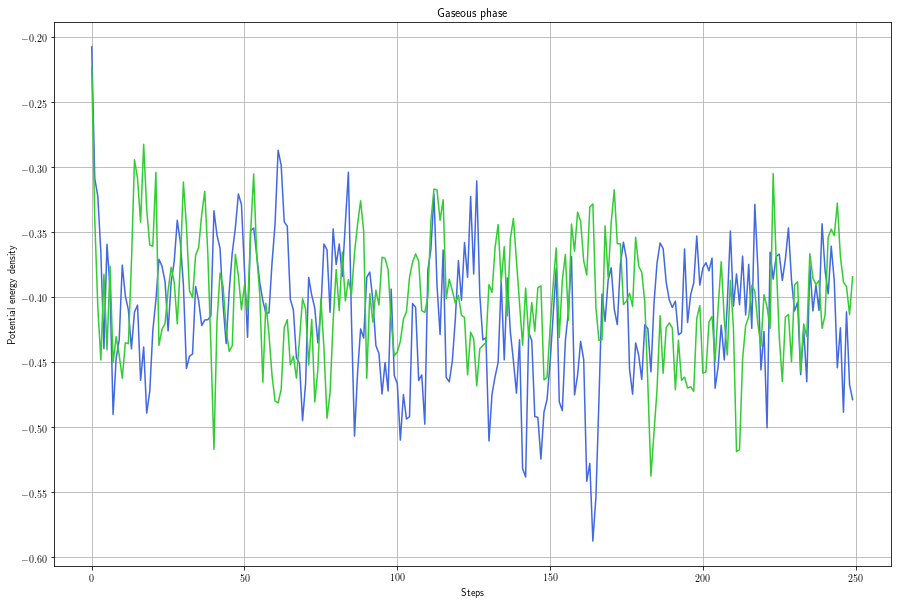

In [3]:
u1, u2 = np.loadtxt(prefix + "warmup_analysis_output.dat", unpack = True)

plt.figure(figsize = (15, 10))
max_steps = 250
plt.title('Gaseous phase')
plt.xlabel('Steps')
plt.ylabel('Potential energy density')
plt.plot(range(max_steps), u1[:max_steps], color = "royalblue")
plt.plot(range(max_steps), u2[:max_steps], color = "limegreen")
plt.grid(True)
plt.show()

It would seem that 50 or 100 steps are enough for the initial transient effects to vanish.

##### Autocorrelation

In [4]:
def autocovariance(series, lag):
    n = len(series)
    mean = 0
    for x in series:
        mean += x
    mean /= n
    c = 0
    for i in range(n - lag):
        c += (series[i] - mean)*(series[i + lag] - mean)
    return c / n

def autocorrelation(series, lag):
    return autocovariance(series, lag) / autocovariance(series, 0)

def autocorrelation_fit(t, t0):
    return [np.exp(-x / t0) for x in t]
    # curve_fit from scipy expects the function to be vectorised.

The estimates of the autocorrelation time for the gaseous phase results are 7.808354935310319 and 1.8418606571893015
The estimates of the autocorrelation time for the liquid phase results are 20.570363421551363 and 26.964524960392158
The estimates of the autocorrelation time for the solid phase results are 19.36003981506434 and 19.03838547028309


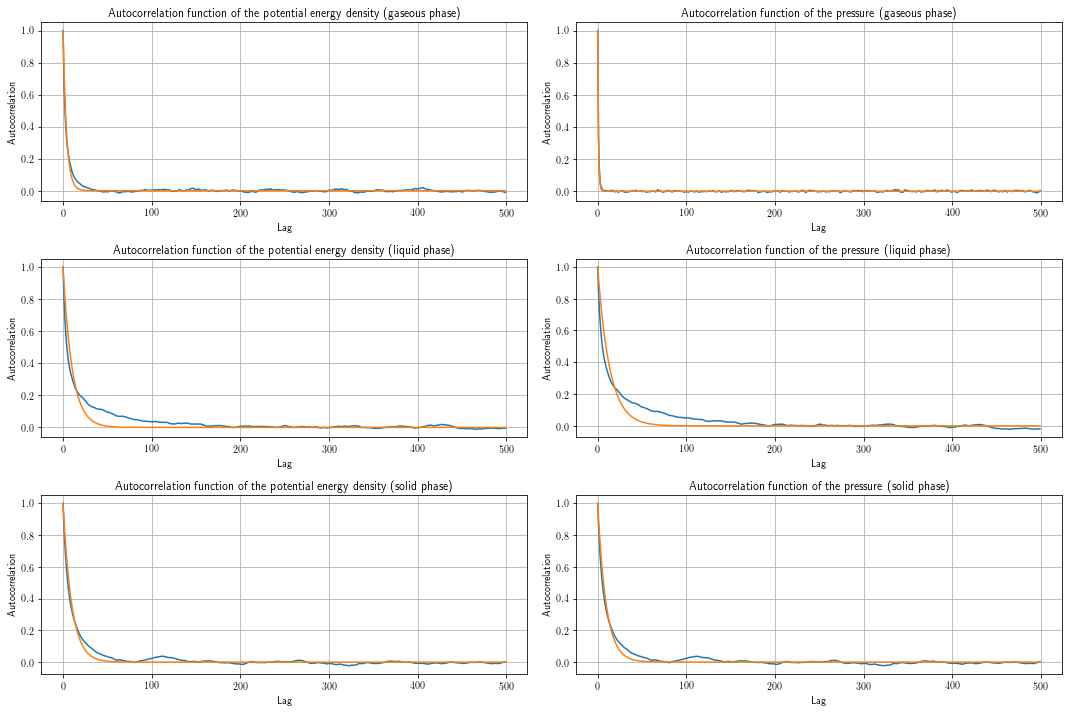

In [5]:
fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (15, 10))
axes = axes.flatten()
phases = ["gaseous", "liquid", "solid"]

for (plot_count, phase) in enumerate(phases):
    u, p = np.loadtxt(prefix + phase + "_output.dat", unpack = True)
    warmup_steps = 100
    max_lag = 500

    u_acf = [autocorrelation(u[warmup_steps:], t) for t in range(max_lag)]
    p_acf = [autocorrelation(p[warmup_steps:], t) for t in range(max_lag)]

    u_autocorrelation_time, u_variance = curve_fit(autocorrelation_fit, range(max_lag), u_acf, p0 = 1)
    p_autocorrelation_time, p_variance = curve_fit(autocorrelation_fit, range(max_lag), p_acf, p0 = 1)
    
    axes[2 * plot_count].grid(True)
    axes[2 * plot_count].set_title("Autocorrelation function of the potential energy density (" + phase + " phase)")
    axes[2 * plot_count].set_xlabel("Lag")
    axes[2 * plot_count].set_ylabel("Autocorrelation")
    axes[2 * plot_count].plot(u_acf, label = "Data")
    axes[2 * plot_count].plot(autocorrelation_fit(range(max_lag), u_autocorrelation_time[0]), label = "Best fit")

    axes[2 * plot_count + 1].grid(True)
    axes[2 * plot_count + 1].set_title("Autocorrelation function of the pressure (" + phase + " phase)")
    axes[2 * plot_count + 1].set_xlabel("Lag")
    axes[2 * plot_count + 1].set_ylabel("Autocorrelation")
    axes[2 * plot_count + 1].plot(p_acf, label = "Data")
    axes[2 * plot_count + 1].plot(autocorrelation_fit(range(max_lag), p_autocorrelation_time[0]), label = "Best fit")

    print("The estimates of the autocorrelation time for the " + phase + " phase results are " + str(2 * u_autocorrelation_time[0]) + " and " + str(2 * p_autocorrelation_time[0]))

fig.tight_layout()
plt.show()

The results above suggest a block length of
- 16 steps for the gaseous phase,
- 54 steps for the liquid phase,
- 40 steps for the solid phase.

###### Estimation of the statistical uncertainty

Here I study the expectation value of the potential energy density and the pressure as the size of the blocks is varied from 10 to 500.

In [6]:
# This function is the usual function that computes an array
# of average values and an array of the associated standard
# deviations, using a blocking technique.
def block_uncertainty(series, block_length):
    n_blocks = int(len(series) / block_length)
    mean  = np.zeros(n_blocks)
    stdev = np.zeros(n_blocks)
    sum_avg    = 0
    sum_sq_avg = 0
    for i in range(n_blocks):
        block_avg = 0
        for j in range(block_length):
            block_avg += series[block_length * i + j]
        block_avg  /= block_length
        sum_avg    += block_avg
        sum_sq_avg += block_avg * block_avg
        mean[i]     = sum_avg / (i + 1)
        if i > 0:
            stdev[i] = np.sqrt((sum_sq_avg / (i + 1) - mean[i] * mean[i]) / i)
    return mean, stdev

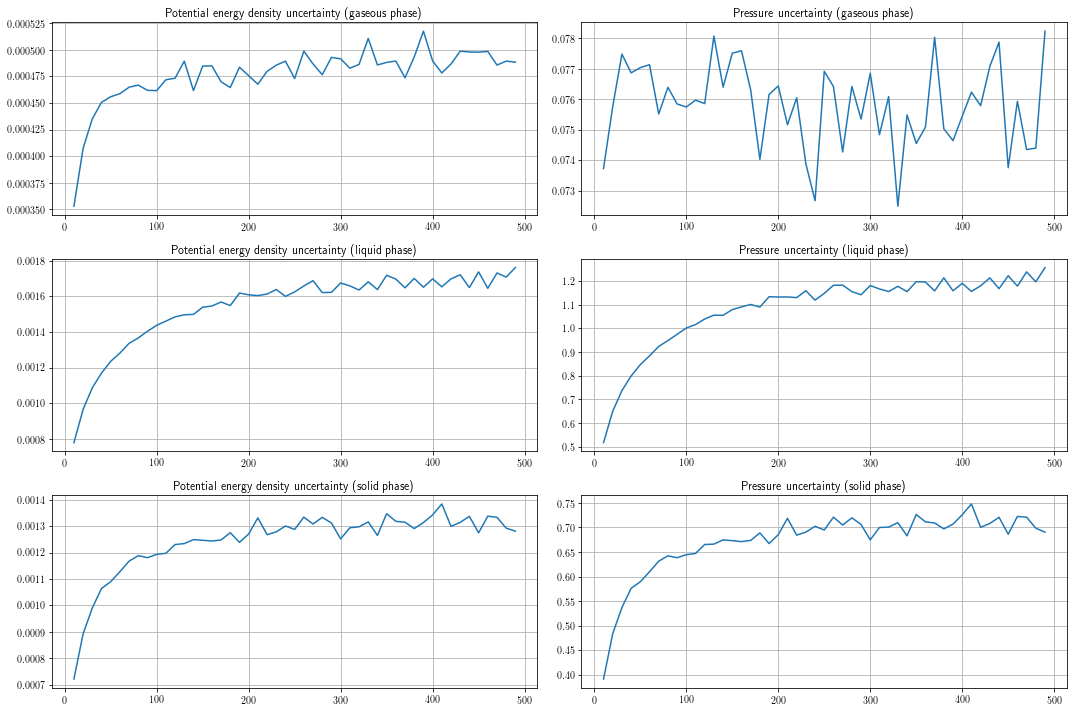

In [8]:
fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (15, 10))
axes = axes.flatten()
phases = ["gaseous", "liquid", "solid"]
warmup_steps = [16, 54, 40]

for (plot_count, phase) in enumerate(phases):
    u, p = np.loadtxt(prefix + phase + "_output.dat", unpack = True)
    u_err = []
    p_err = []
    for block_length in range(10, 500, 10):
        # The data in the warm-up period is excluded.
        u_mean, u_stdev = block_uncertainty(u[warmup_steps[plot_count]:], block_length)
        p_mean, p_stdev = block_uncertainty(p[warmup_steps[plot_count]:], block_length)
        u_err.append(u_stdev[-1])
        p_err.append(p_stdev[-1])
    
    axes[2 * plot_count].grid(True)
    axes[2 * plot_count].set_title("Potential energy density uncertainty (" + phase + " phase)")
    axes[2 * plot_count].plot(range(10, 500, 10), u_err)
    
    axes[2 * plot_count + 1].set_title("Pressure uncertainty (" + phase + " phase)")
    axes[2 * plot_count + 1].grid(True)
    axes[2 * plot_count + 1].plot(range(10, 500, 10), p_err)
    
fig.tight_layout()
plt.show()

It is clear from these plots that the uncertainties become close to a certain value (specific to the system) when the number of blocks is large enough.

#### Exercise 07.2

In [2]:
prefix = "exercise07-2/"

###### Monte Carlo simulation
The following plots show the radial distribution function of the particles, simulating the evolution of the systems with the Metropolis algorithm at a fixed temperature. 
The x axis represents the distance in reduced units.

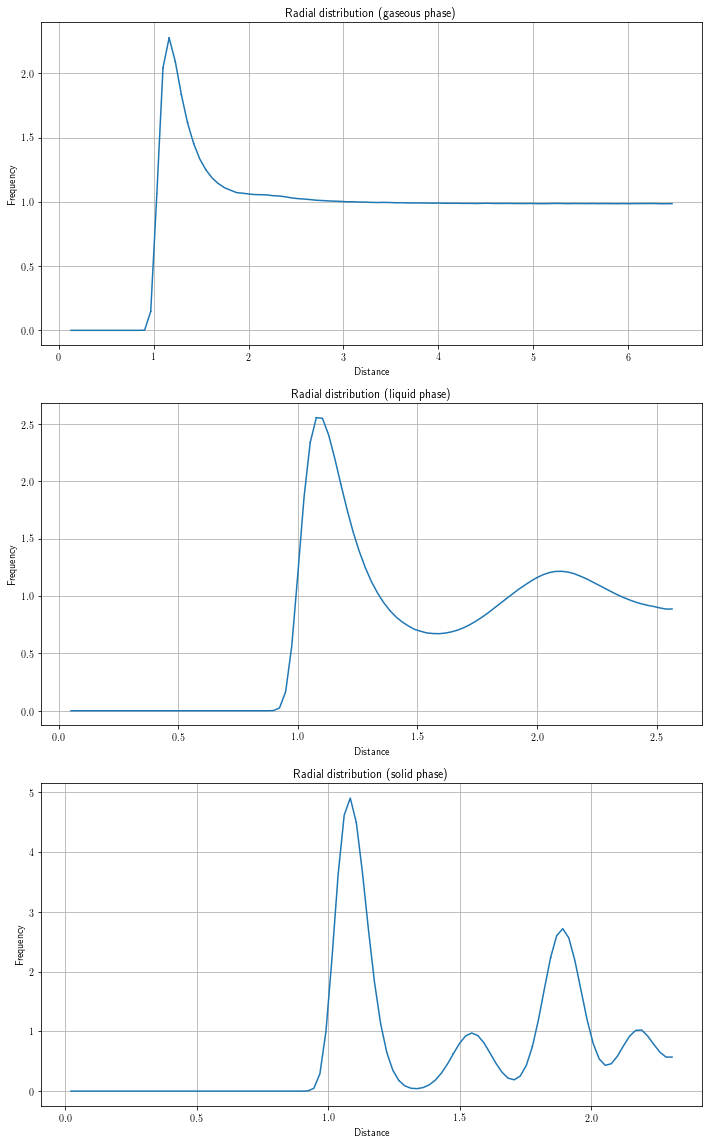

In [5]:
phases = ["gaseous", "liquid", "solid"]
fig, axes = plt.subplots(nrows = 3, ncols = 1, figsize = (10, 16))
axes = axes.flatten()

for (plot_count, phase) in enumerate(phases):
    bins, rd_avg, rd_err = np.loadtxt(prefix + phase + "_output.gave.0", unpack = True, skiprows = 1)
    axes[plot_count].set_title("Radial distribution (" + phase + " phase)")
    axes[plot_count].set_xlabel('Distance')
    axes[plot_count].set_ylabel('Frequency')
    axes[plot_count].errorbar(bins, rd_avg, yerr = rd_err)
    axes[plot_count].grid(True)

fig.tight_layout()
plt.show()